In [1]:
## Import Packages 

import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
from matplotlib.mlab import PCA as mlabPCA
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

# Import Files
df = pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls")

In [2]:
## View Raw File
#pd.read_excel("table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls")
#df.dtypes

In [3]:
### Clean Data

## Create DataFrame Columns

df.columns = ['city', 'population','violent_crime', 
                    'murder', 'rape_revised','rape_legacy', 
                    'robbery', 'aggravated_assault', 'property_crime', 
                    'burglary', 'larceny_theft', 'vehicle_theft', 'arson']

## Drop extraneous rows and columns

df = df.drop(df.index[:4])
df = df.drop(df.index[-3:])
df = df.drop('rape_revised', axis=1 )

## Change Data Types of Columns

df.loc[:,'city'] = df.loc[:,'city'].apply(str)
df = df.apply(pd.to_numeric, errors='ignore')

## Replace extreme values with 95th percentile

up_quantiles = df.quantile(0.95)
outliers_high = (df > df.quantile(0.95))
df[outliers_high] = np.nan
df.fillna(up_quantiles, inplace=True)

## Reset index

df.reset_index(inplace=True)
df.drop("index",axis=1,inplace=True)

In [4]:
## View Cleaned Data
df.head(10)
#df.dtypes
#df.describe()

,city,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
0,Adams Village,1861.000,0.000,0.000,0.000,0.000,0.000,12.000,2.000,10.000,0.000,0.000
1,Addison Town and Village,2577.000,3.000,0.000,0.000,0.000,3.000,24.000,3.000,20.000,1.000,0.000
2,Akron Village,2846.000,3.000,0.000,0.000,0.000,3.000,16.000,1.000,15.000,0.000,0.000
3,Albany,56732.650,155.900,1.650,10.300,56.850,88.300,1377.700,222.250,1178.500,50.300,4.700
4,Albion Village,6388.000,23.000,0.000,3.000,4.000,16.000,223.000,53.000,165.000,5.000,4.700
5,Alfred Village,4089.000,5.000,0.000,0.000,3.000,2.000,46.000,10.000,36.000,0.000,4.700
6,Allegany Village,1781.000,3.000,0.000,0.000,0.000,3.000,10.000,0.000,10.000,0.000,0.000
7,Amherst Town,56732.650,107.000,1.000,7.000,31.000,68.000,1377.700,204.000,1178.500,32.000,3.000
8,Amityville Village,9519.000,9.000,0.000,2.000,4.000,3.000,210.000,16.000,188.000,6.000,1.000
9,Amsterdam,18182.000,30.000,0.000,0.000,12.000,18.000,405.000,99.000,291.000,15.000,0.000


# Multivariable Regression Analysis of FBI Data #

FBI crime data was used to create a model predicting property crimes.

## Analyzing the Data

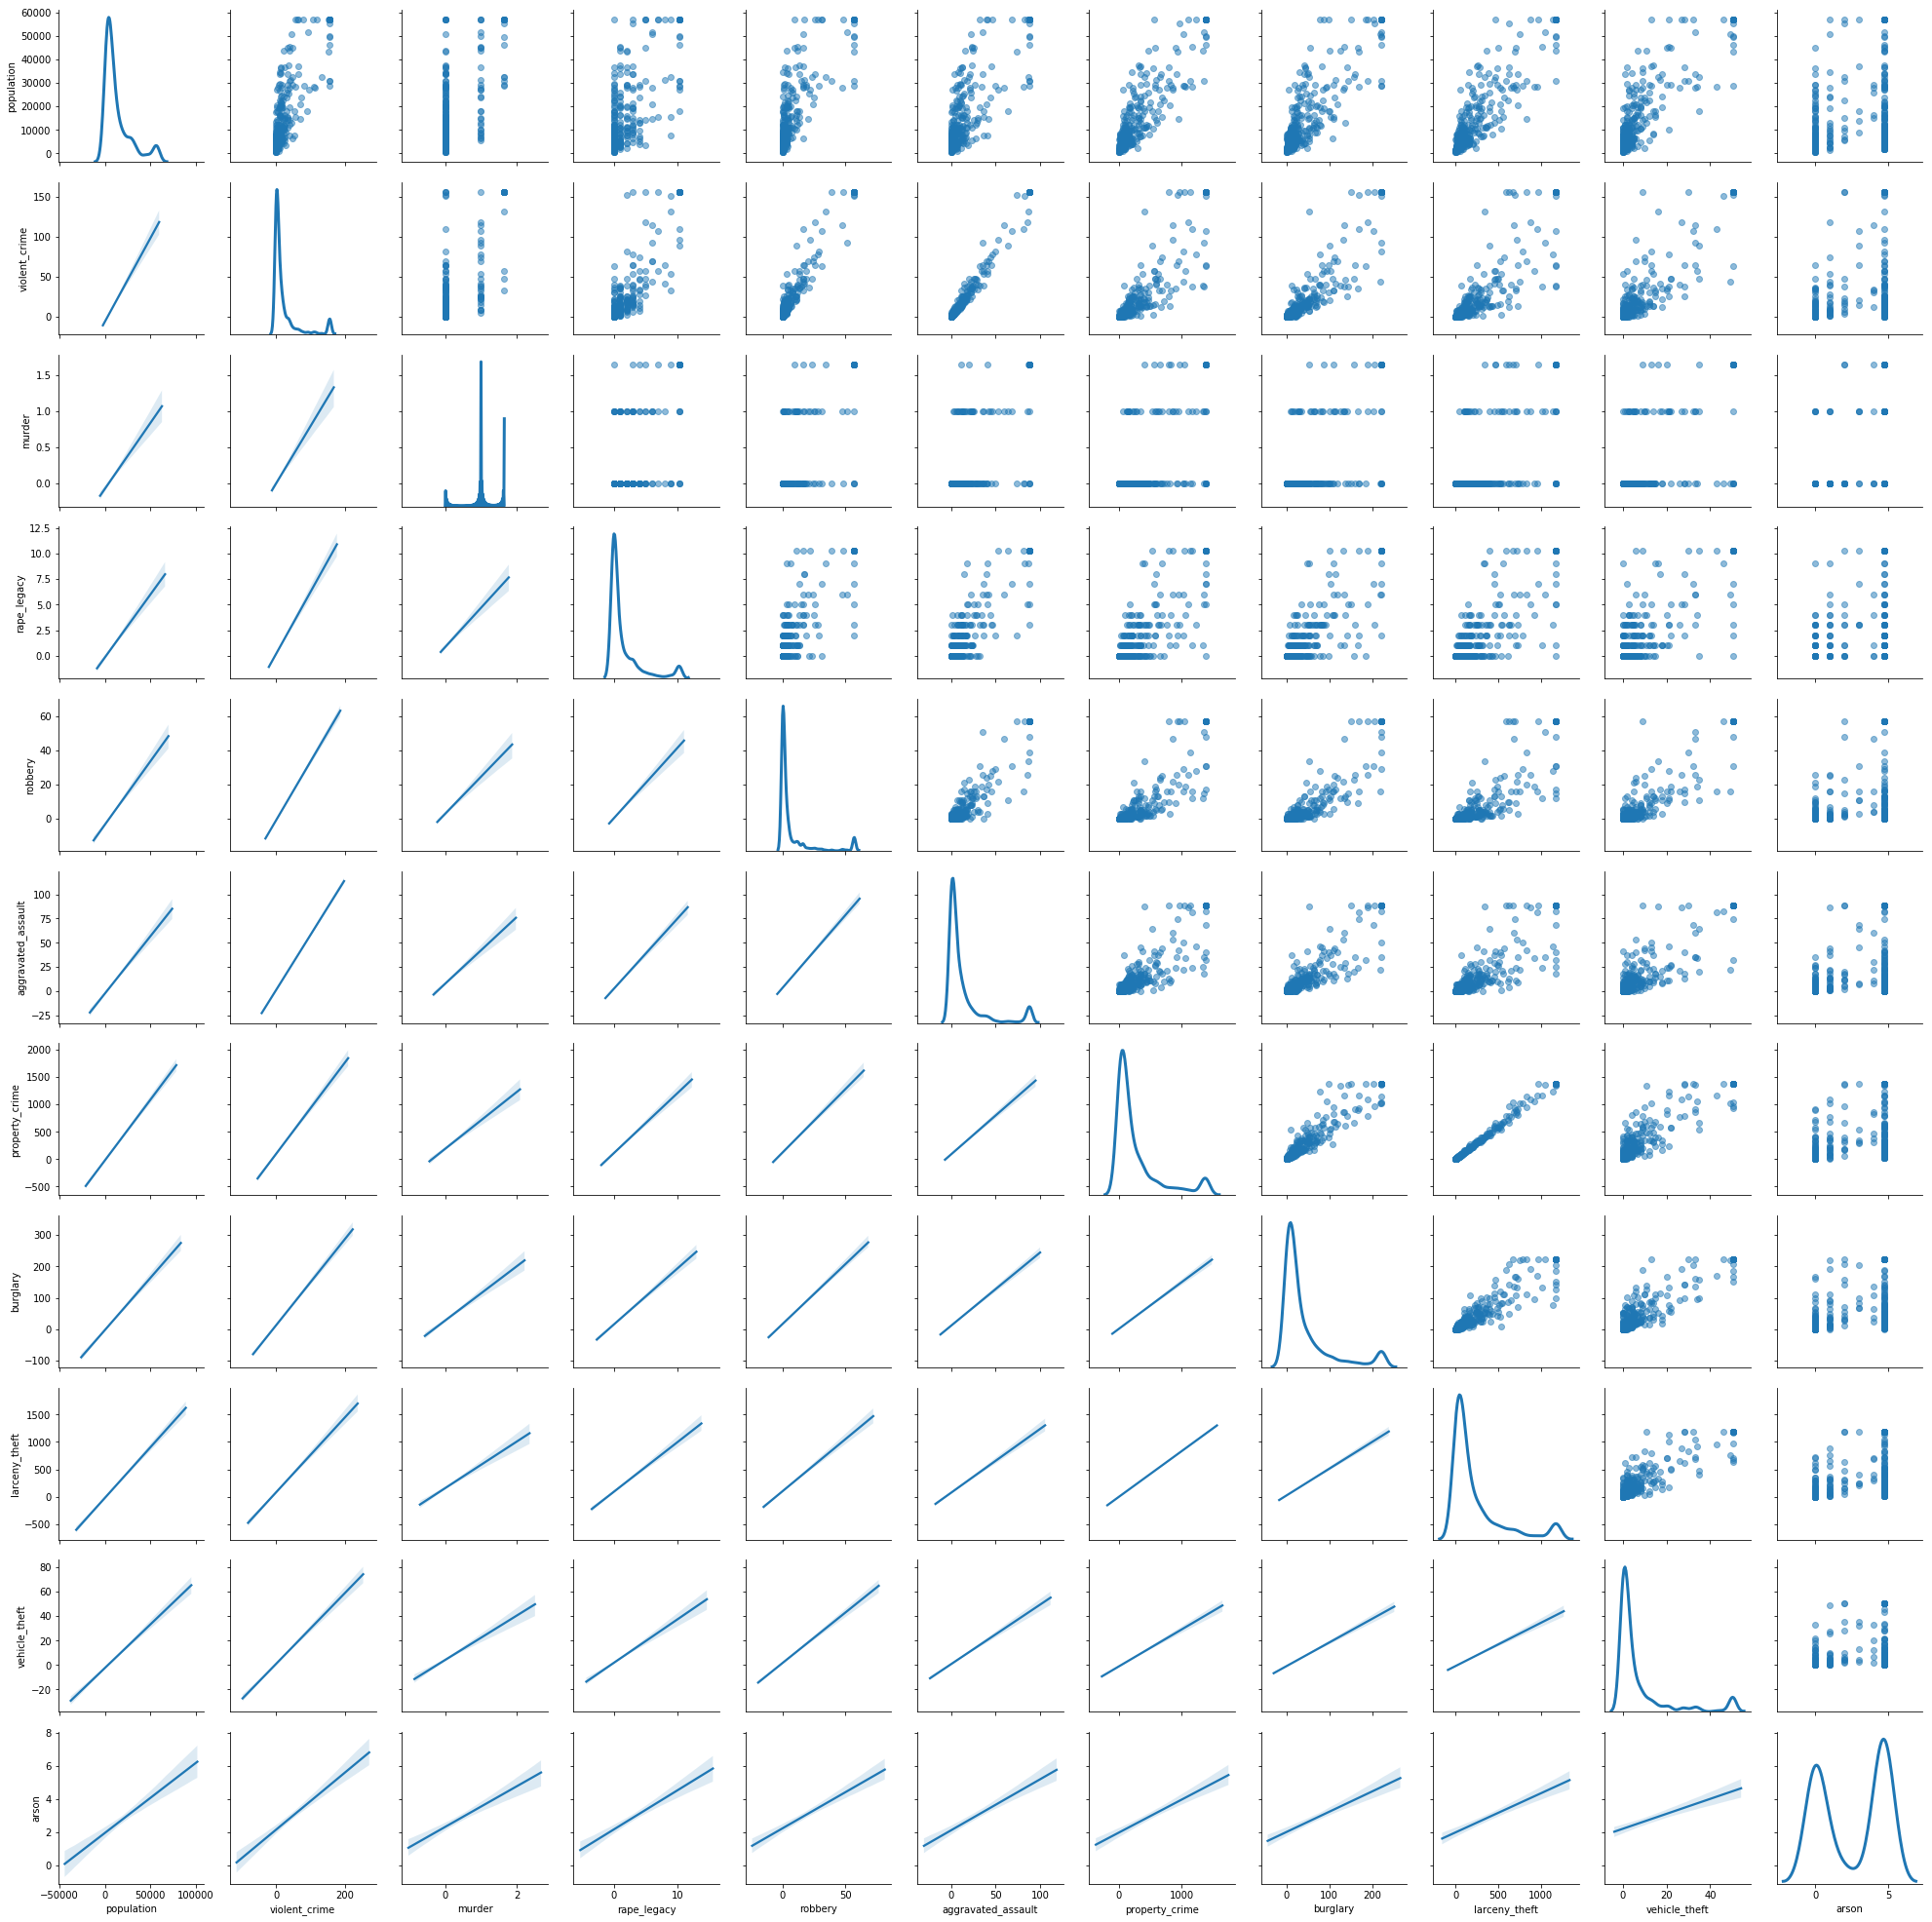

In [5]:
## Creating Scatterplot Matrix

## Declare Pairgrid
g = sns.PairGrid(df.dropna(), diag_sharey=False)

## Scatterplot
g.map_upper(plt.scatter, alpha=.5)

## Fit line 
g.map_lower(sns.regplot, scatter_kws=dict(alpha=0))

## KDE plot
g.map_diag(sns.kdeplot, lw=3)
plt.show()

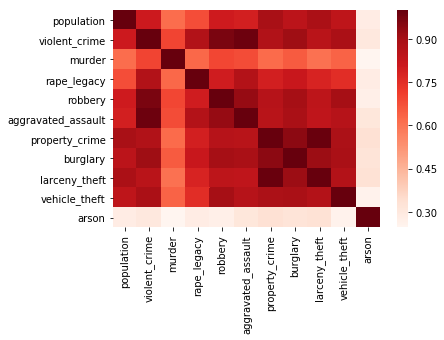

In [6]:
## Visualizing the Correlatedness of the variables

sns.heatmap(df.corr(), cmap='Reds')
plt.show()

High correlatedness of variables may lead to overfitting.

In [7]:
## View Descriptive Statistics

df.describe()

,population,violent_crime,murder,rape_legacy,robbery,aggravated_assault,property_crime,burglary,larceny_theft,vehicle_theft,arson
count,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000
mean,13558.034,22.374,0.174,1.530,6.754,13.725,279.513,42.780,230.833,7.314,2.539
std,15126.303,39.108,0.447,2.726,13.942,22.584,374.551,58.932,313.592,12.790,2.230
min,526.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,0.000,1.000,4.000,112.500,17.500,94.000,2.000,4.000
75%,18427.500,22.000,0.000,2.000,5.000,14.000,341.000,51.250,287.250,7.000,4.700
max,56732.650,155.900,1.650,10.300,56.850,88.300,1377.700,222.250,1178.500,50.300,4.700


## Creating a Model Based on the Data's Original Features

### Selecting Features

In [8]:
## Storing Feature and Target Variables

features = df.loc[:, ['population', 'violent_crime', 'murder', 'rape_legacy',
       'robbery', 'aggravated_assault', 'burglary',
      'larceny_theft', 'vehicle_theft', 'arson'
           ]].dropna()

target = df['property_crime']

### Creating the Model

In [9]:
## Storing Feature and Target Variables for the Model
x = features
y = target

## Creating the Model and fitting it to the data
regr = linear_model.LinearRegression()
regr.fit(x, y)

## Display the attributes we calculated
print('Coefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:\n', regr.score(x, y))



Coefficients: 
 [ 1.23999631e-04  3.49019790e+00  7.69482537e-01 -4.84154596e+00
 -3.91121990e+00 -3.50498386e+00  1.11942772e+00  9.84862225e-01
  6.98480799e-01  1.57032211e-01]

Intercept: 
 0.8008565619797423

R-squared:
 0.9981682644467178


The high R-squared value is a sign of overfitting.

### Evaluating the Regression Model

In [10]:
## Using Single Holdout Group

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(x, y).score(x, y)))

With 20% Holdout: 0.9983592046490116
Testing on Sample: 0.9981682644467178


In [11]:
## Using Cross Validation

cross_val_score(regr, x, y, cv=10)

array([0.99906607, 0.9968466 , 0.99965971, 0.99859132, 0.99649617,
       0.98304469, 0.99912078, 0.99922165, 0.99896875, 0.99900923])

In [12]:
## Definine RMSE function for frequent use

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

## Calculating Model RMSE

print('RMSE: ' + str(rmse(regr.predict(x), y)))

RMSE: 16.007296210465828


The high  scores from the holdout groups and cross validation is a sign of overfitting.

## Creating a Model Based using Principal Components Analysis 

A second model was created using principal components analysis to address the high multicollinearity of the variables.

### Principal Components Analysis

In [13]:
## Normalize the data for PCA

X = StandardScaler().fit_transform(features)

In [14]:
## Perform PCA

sklearn_pca = PCA(n_components=2)
Y_sklearn = sklearn_pca.fit_transform(X)

In [15]:
## Evaluate PCA

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.76538122 0.08902699]


In [16]:
## Turn PCA Result into Dataframe

pca_components = pd.DataFrame(data=Y_sklearn
             , columns = ['component_1', 'component_2'])

## Store DataFrame For Regression

df_for_regression = pd.concat([pca_components, target], axis = 1)

In [17]:
df_for_regression.head(15)

,component_1,component_2,property_crime
0,-1.928,0.908,12.000
1,-1.797,0.928,24.000
2,-1.835,0.920,16.000
3,9.742,0.334,1377.700
4,-0.058,-0.991,223.000
5,-1.380,-1.137,46.000
6,-1.869,0.918,10.000
7,6.885,0.594,1377.700
8,-0.818,0.593,210.000
9,0.527,1.240,405.000


### Creating the Regression Model

In [18]:
## Store features and targets for regression

x_2 = df_for_regression[['component_1', 'component_2']]
y_2 = df_for_regression['property_crime']

Coefficients: 
 [127.58167038  -0.68892023]

Intercept: 
 279.5132183908045

R-squared:
 0.8905999243314461


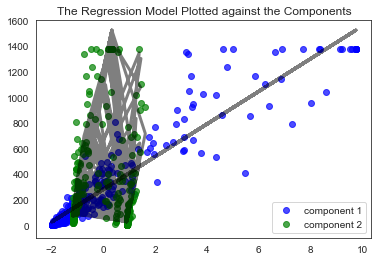

In [19]:
# Instantiate our model.
regr_2 = linear_model.LinearRegression()

# Fit our model to our data.
regr_2.fit(x_2, y_2)

# Display the attributes we calculated.
print('Coefficients: \n', regr_2.coef_)
print('\nIntercept: \n', regr_2.intercept_)
print('\nR-squared:\n', regr_2.score(x_2, y_2))

# Plot outputs
sns.set_style("white")

plt.scatter(pca_components['component_1'], y_2, color='blue', alpha=.7, label = 'component 1')
plt.scatter(pca_components['component_2'], y_2, color='green', alpha=.7, label = 'component 2')
plt.plot(x_2, regr_2.predict(x_2), color='black', linewidth=3, alpha=.5)
plt.title('The Regression Model Plotted against the Components')
plt.legend()
plt.show()

### Evaluating the Regression Model

In [20]:
## Using Single Holdout Group

X_train, X_test, y_train, y_test = train_test_split(x_2, y_2, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr_2.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr_2.fit(x_2, y_2).score(x_2, y_2)))

With 20% Holdout: 0.9412472088223672
Testing on Sample: 0.8905999243314461


In [21]:
## Cross Validation

cross_val_score(regr_2, x_2, y_2, cv=10)

array([0.96857129, 0.89355429, 0.77408569, 0.85115139, 0.88646889,
       0.9120926 , 0.84702736, 0.83291684, 0.86805975, 0.91934414])

In [22]:
## Calculate RMSE

print('RMSE: ' + str(rmse(regr_2.predict(x_2), y_2)))

RMSE: 123.70732193154157


Uneven scores from holdout groups and cross validation is still a sign of overfitting. Increase of RMSE and general decreases in scores in the cross valdation suggests there is less overfitting than in previous model.

## Reflecting on the Modeling Process

I originally used all of the continuous variables to engineer the first model. The cross validation scores were too high, implying overfitting. I performed a principal component analysis on all of the original variables and use the resulting components for a second model to improve performance. I chose to use only the 2 most useful features since together they already accounted for 85% of the variance in the variables. The cross validation scores still implied overfitting.